# Imports and paths

In [46]:
import os
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib as mpl
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
%matplotlib inline
mpl.rcParams.update({'font.size':10})
plasma_map = plt.cm.plasma(np.linspace(0,1,15))
kcolors = {
    'movement': plasma_map[12,:],
    'early': plasma_map[10,:],
    'late': plasma_map[8,:],
    'biphasic': plasma_map[5,:],
    'negative': plasma_map[2,:],
    'unresponsive': 'dimgrey'
}
tcolors = {
    'gaze': 'firebrick',
    'comp': 'mediumblue',
    'rc': 'indigo'
}

In [47]:
psth_bins = np.arange(-200,401)

In [48]:
# savepath = '/home/niell_lab/Desktop/'
data = loadmat('/home/niell_lab/Data/marmoset/gazeshift/Pooled_V1Hart_Preload_Final.mat')
# totdata = loadmat('/home/niell_lab/Data/marmoset/gazeshift/Pooled_V1Hart_Preload_TotalInfo.mat')['TotalInfo']

# Rasters for example units

In [4]:
def mRaster(ax, rast, n=500):
    usetrials = np.array(sorted(np.random.choice(np.arange(0,int(np.max(rast[:,1]))), n, replace=False)))
    
    for row, tnum in enumerate(usetrials):
        sps = rast.copy()
        sps = sps[sps[:,1].astype(int)==tnum]
        sps = sps[:,0]
        
        ax.plot(sps, np.ones(sps.size)*row, '|', color='k', markersize=0.3)
        
    ax.set_xlim([-0.2,0.4])
    ax.set_ylim([n, 0])
    ax.set_yticks(np.linspace(0,n,3))
    
    ax.set_xticks(np.linspace(-.2,.4,4))
    ax.set_xticklabels([])
    # ax.set_xticklabels(np.linspace(-200,400,4).astype(int))

In [11]:
raw_sacc = np.load('/home/niell_lab/Desktop/marmoset_recalc_saccades.npy')
raw_sacc.shape

(334, 601)

/home/niell_lab/anaconda3/envs/ephys0/lib/python3.8/site-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/home/niell_lab/anaconda3/envs/ephys0/lib/python3.8/site-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/home/niell_lab/anaconda3/envs/ephys0/lib/python3.8/site-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


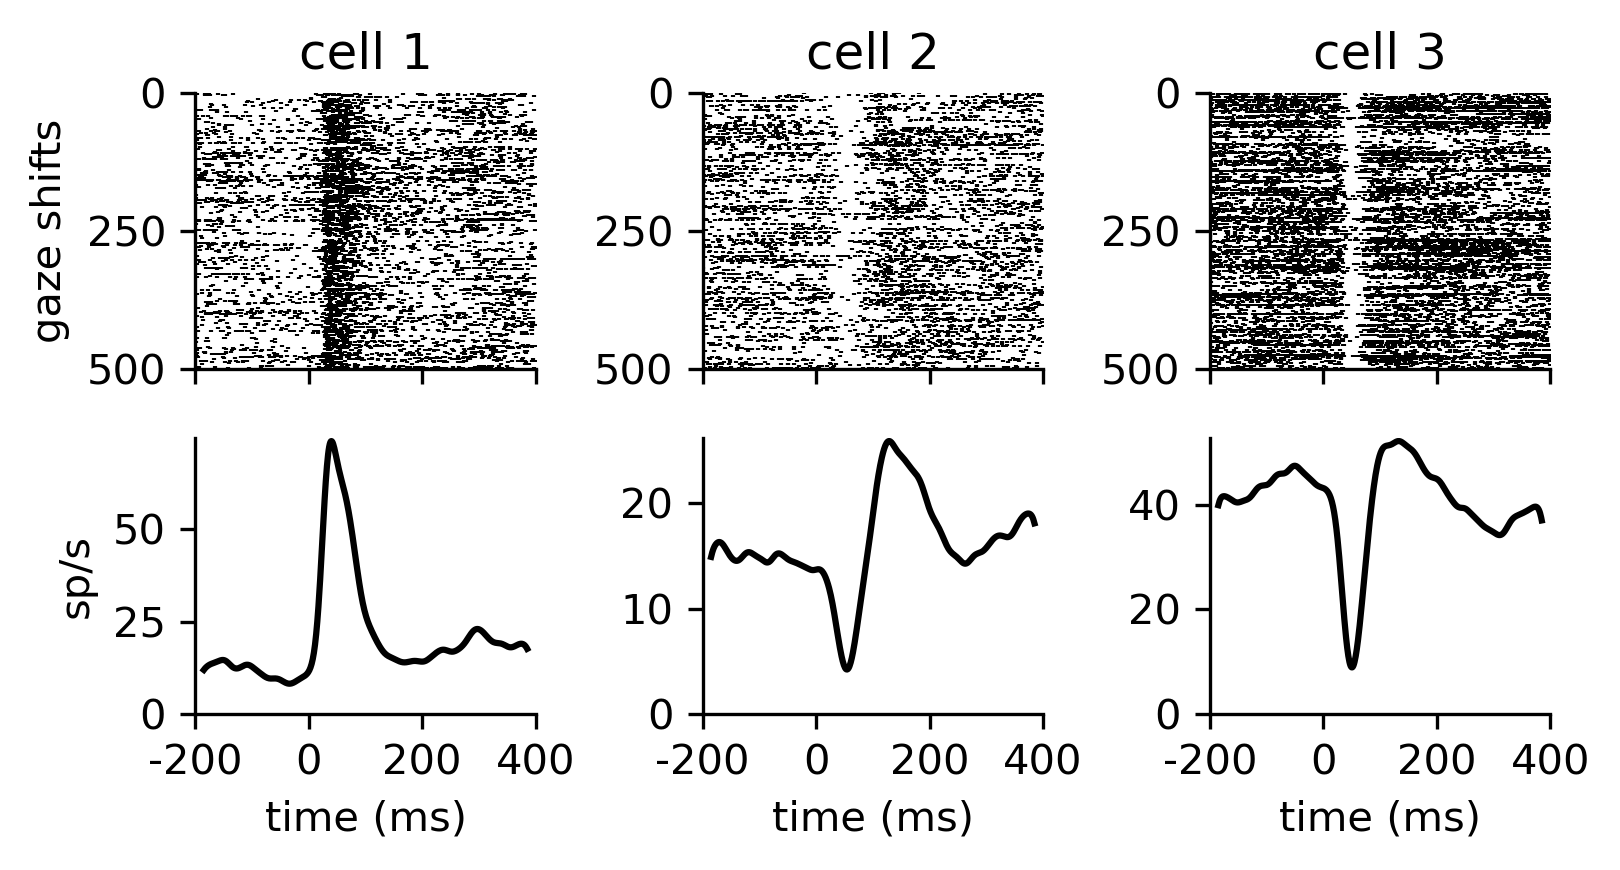

In [25]:
example_units = [9, 30, 0]

fig, axs = plt.subplots(2,3, figsize=(5.5,3), dpi=300)

for uPos, uNum in enumerate(example_units):

    unitlabels = ['tagname','pathname','pathplot','isolation','depth','duration',
                  'waveform','channel','shank','ISI','Hart','SacGrating','SacImage']
    unit_dict = dict(zip(unitlabels, list(totdata[uNum][0][0][0])))

    sacimlabels = ['EventList','StimWin','TrialType','StimRast','OriInd','StimTT',
                   'StimUU','StimSU','OriInd2','StimRast2','StimTT2','StimUU2',
                   'StimSU2','BaseMu','BaseMu2']
    sacim_dict = dict(zip(sacimlabels, list(unit_dict['SacImage'][0][0])))

#     hartlabels = ['SFcurve','stcounts','stsem','NOri','NSpf','SpatOris','SpatFrqs',
#                   'tXX','tempker','sgcounts','sgsem','Ori','OI','SFI','SpatFreq',
#                   'ymean','uu','su','otune','sotune','stune','sstune','MyTick','MyTickLabel',
#                   'mcounts','msem','pcounts','psem','tcrit','trepa','trepb','FileTag']
#     hart_dict = dict(zip(hartlabels, list(unit_dict['Hart'][0][0])))

    mRaster(axs[0,uPos], sacim_dict['StimRast2'], 500)
    if uPos==0:
        axs[0,uPos].set_ylabel('gaze shifts')
    
    axs[0,uPos].set_title('cell {}'.format(uPos+1))

    # psth = data['ISACMOD2'][uNum]
    psth = raw_sacc[uNum,:].copy()
    psth_bins = np.arange(-200,401,1)
    psth[:15] = np.nan
    psth[-15:] = np.nan
    axs[1,uPos].plot(psth_bins, psth, 'k-')
    axs[1,uPos].vlines(0,0,np.max(psth)*1.1, 'k', linestyle='dashed',linewidth=1)
    
    # axs[1,uPos].plot(sacim_dict['StimTT'].flatten(), sacim_dict['StimUU'].flatten(), 'k-')
    # axs[1,uPos].vlines(0,0,np.max(sacim_dict['StimUU'].flatten())*1.1, 'k', linestyle='dashed',linewidth=1)
    if uPos==0:
        axs[1,uPos].set_ylabel('sp/s')
    axs[1,uPos].set_xticks(np.linspace(-200,400,4))
    axs[1,uPos].set_xlim([-200,400])
    axs[1,uPos].set_xticklabels(np.linspace(-200,400,4).astype(int))
    axs[1,uPos].set_xlabel('time (ms)')
    axs[1,uPos].set_ylim([0, np.nanmax(psth)*1.01])

    # axs[2,uPos].plot(hart_dict['SpatOris'].flatten(),
    #               np.array(hart_dict['otune'].flatten())[:int(np.size(hart_dict['SpatOris'].flatten()))],
    #               color='k')
    # axs[2,uPos].set_xticks(hart_dict['SpatOris'].flatten()[::2].astype(int))
    # axs[2,uPos].set_xlabel('orientation (deg)')
    # axs[2,uPos].set_ylabel('sp/s')

fig.tight_layout()

fig.savefig(os.path.join(savepath, '6_example_cells_081022.pdf'))

# Cross validation

In [49]:
cv_psth = np.load('/home/niell_lab/Desktop/crossval.npy')
cv_psth.shape

(334, 2, 601)

In [50]:
cv_norm_psth = np.zeros(cv_psth.shape)
cv_peakT = np.zeros([334,2])
for u in range(334):
    for x in range(2):
        n = normalize_psth(cv_psth[u,x,:].copy())
        cv_norm_psth[u,x,:] = n
        cv_peakT[u,x] = np.argmax(n[220:450])+20

([<matplotlib.axis.YTick at 0x7fd0aeda6af0>,
 [Text(0, 20.0, '20'),
  Text(0, 96.66666666666667, '96'),
  Text(0, 173.33333333333334, '173'),
  Text(0, 250.0, '250')])

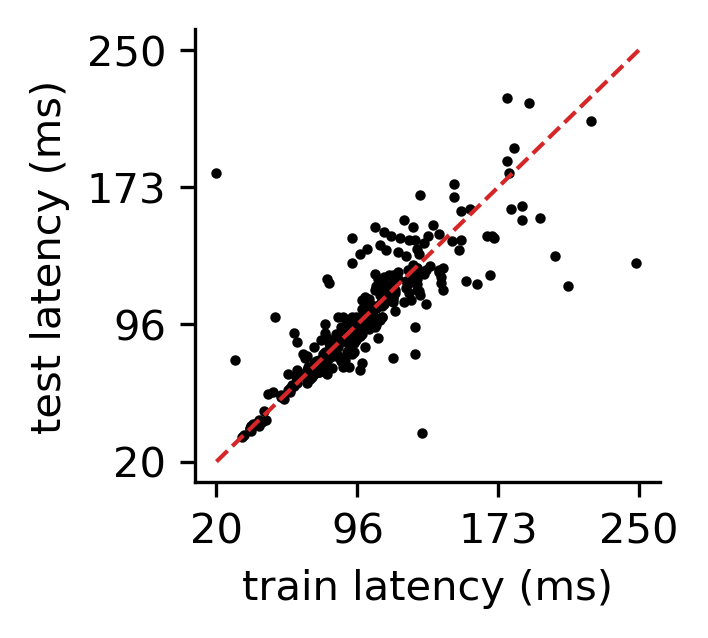

In [51]:
plt.figure(figsize=(2,2), dpi=300)
plt.plot(cv_peakT[:,0], cv_peakT[:,1], 'k.', markersize=3)
plt.xlabel('train latency (ms)'); plt.ylabel('test latency (ms)')
plt.plot([20,250], [20,250], linestyle='dashed', color='tab:red', linewidth=1)
# plt.xlim([20,250]); plt.ylim([20,250])
plt.xticks(np.linspace(20,250,4), labels=np.linspace(20,250,4).astype(int))
plt.yticks(np.linspace(20,250,4), labels=np.linspace(20,250,4).astype(int))
# plt.savefig('/home/niell_lab/Desktop/marmoset_latency_crossval.pdf', pad_inches=3)

In [53]:
from scipy.stats import spearmanr

In [54]:
spearmanr(cv_peakT[:,0], cv_peakT[:,1])

SpearmanrResult(correlation=0.8748997859872495, pvalue=1.4384102431538663e-106)

In [1]:
from scipy.stats import linregress

res = linregress(cv_peakT[:,0], cv_peakT[:,1])

In [1]:
res.rvalue

In [ ]:
res.rvalue**2

In [42]:
latency_sort = np.argsort(cv_peakT[:,0].flatten().copy())
train_tseq = cv_norm_psth[:,0,:].copy()[latency_sort]
test_tseq = cv_norm_psth[:,1,:].copy()[latency_sort]

In [53]:
test_tseq.shape

(334, 601)

In [66]:
def plot_tempseq(panel, tseq, return_img=False, freev=None):
    # tseq = drop_nan_along(tseq, 1)
    panel.set_xlabel('msec')
    panel.set_ylim([np.size(tseq,0),0])
    vmin = -0.75; vmax = 0.75
    if freev is not None:
        vmin = -freev
        vmax = freev
    tseq[:,:5] = np.nan
    tseq[:,-5:] = np.nan
    img = panel.imshow(tseq, cmap='coolwarm', vmin=vmin, vmax=vmax)
    panel.set_xlim([0,601])
    panel.set_yticks(np.arange(0, np.size(train_tseq,0),100))
    panel.set_xticks(np.linspace(0,601,4), labels=np.linspace(-200,400,4).astype(int))
    panel.vlines(200, 0, np.size(tseq,0), color='k', linestyle='dashed', linewidth=1)
    panel.set_aspect(2.8)
    if return_img:
        return img

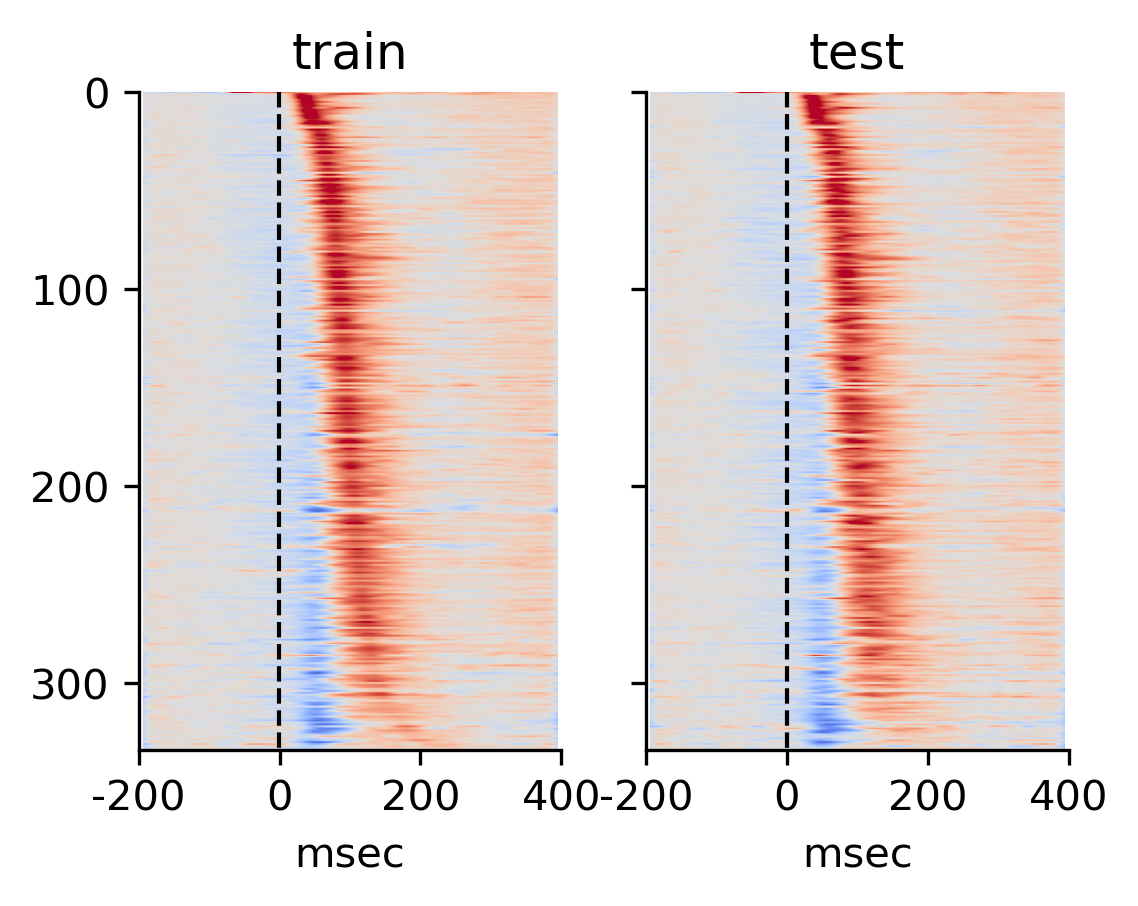

In [70]:
fig, [ax0,ax1] = plt.subplots(1,2,figsize=(4,4), dpi=300)

ax0_img = plot_tempseq(ax0, train_tseq)

ax1_img = plot_tempseq(ax1, test_tseq)
ax1.set_yticklabels([])

ax0.set_title('train')
ax1.set_title('test')

fig.savefig('/home/niell_lab/Desktop/marmoset_crossval.pdf', pad_inches=3)

In [ ]:
# uNum = 10

# unitlabels = ['tagname','pathname','pathplot','isolation','depth','duration',
#               'waveform','channel','shank','ISI','Hart','SacGrating','SacImage']
# unit_dict = dict(zip(unitlabels, list(totunits[uNum][0][0][0])))

# sacimlabels = ['EventList','StimWin','TrialType','StimRast','OriInd','StimTT',
#                'StimUU','StimSU','OriInd2','StimRast2','StimTT2','StimUU2',
#                'StimSU2','BaseMu','BaseMu2']
# sacim_dict = dict(zip(sacimlabels, list(unit_dict['SacImage'][0][0])))

# rast = sacim_dict['StimRast2'].copy()

# trials = np.unique(rast[:,1]).astype(int)-1

# train_inds = np.array(sorted(np.random.choice(trials, size=int(np.floor(trials.size/2)), replace=False)))
# test_inds = trials.copy()
# test_inds = np.delete(test_inds, train_inds)

# all_sps = []
# for tnum in train_inds:
#     sps = rast.copy()
#     sps = sps[sps[:,1].astype(int)==int(tnum)]
#     sps = sps[:,0]
#     all_sps.extend(sps)
    
# # PSTH
# psth = calc_PSTH(np.array(all_sps), np.zeros(train_inds.size), bandwidth=5, win=400)
# psth = psth[200:800]
# # normalize
# norm_psth = normalize_psth(psth)

In [ ]:
unitlabels = ['tagname','pathname','pathplot','isolation','depth','duration',
              'waveform','channel','shank','ISI','Hart','SacGrating','SacImage']

sacimlabels = ['EventList','StimWin','TrialType','StimRast','OriInd','StimTT',
               'StimUU','StimSU','OriInd2','StimRast2','StimTT2','StimUU2',
               'StimSU2','BaseMu','BaseMu2']

crossval = {}

for uPos, uNum in tqdm(enumerate(range(601))):
    
    unit_dict = dict(zip(unitlabels, list(totunits[uNum][0][0][0])))

    sacim_dict = dict(zip(sacimlabels, list(unit_dict['SacImage'][0][0])))

    rast = sacim_dict['StimRast2'].copy()

    trials = np.unique(rast[:,1]).astype(int)-1

    train_inds = np.array(sorted(np.random.choice(trials, size=int(np.floor(trials.size/2)), replace=False)))
    test_inds = trials.copy()
    test_inds = np.delete(test_inds, train_inds)
    
    prop_dict = {}

    for tt, tname in enumerate(['train', 'test']):
        
        inds = [train_inds, test_inds][tt]
    
        all_sps = []
        for tnum in inds:
            sps = rast.copy()
            sps = sps[sps[:,1].astype(int)==int(tnum)]
            sps = sps[:,0]
            all_sps.extend(sps)

        # PSTH
        psth = calc_PSTH(np.array(all_sps), np.zeros(inds.size), bandwidth=5, win=400)
        psth = psth[200:800]
        norm_psth = normalize_psth(psth)

        # latency
        peakT = np.argmax(norm_psth)-200 # in ms since onset of eye movement\
        
        prop_dict['{}_rawPsth'.format(tname)] = psth
        prop_dict['{}_normPsth'.format(tname)] = norm_psth
        prop_dict['{}_peakT'.format(tname)] = peakT
        
    crossval[uNum] = prop_dict

# Open in arrays

In [49]:
sacc_psth = data['ISACMOD2']
grat_psth = data['GSACMOD']
sf_tuning = data['SFTUNE']
tf_tuning = data['TFTUNE']
ori_tuning = data['ORTUNE']
bsln_fr = data['BASEMU2']
peakT = data['PEAKIM2']
animal = data['ANIMID']

In [50]:
def normalize_psth(psth):
    pref = psth.copy()
    bsln = np.mean(psth[0:150]) # was -100 to -50 ms ; now, -200 to -50 ms
    norm_psth = (psth - bsln) / np.max(pref[200:]) # 0 to 200
    return norm_psth

n_cells = np.size(peakT,0)

norm_sacc_psth = np.zeros([n_cells, len(psth_bins)])
for ind in range(n_cells):
    norm_sacc_psth[ind,:] = normalize_psth(sacc_psth[ind].copy())

# Grat prefs

In [51]:
# spatial and temporal frequencies used
sf_vals = np.array([1,2,4,8,16])
tf_vals = (60/16) * np.arange(9)

tf_pref = np.zeros(n_cells); sf_pref = np.zeros(n_cells)
ori_index = np.zeros(n_cells); tf_index = np.zeros(n_cells); sf_index = np.zeros(n_cells);

for ind in range(n_cells):
    sf = sf_tuning[ind,:].copy()
    tf = tf_tuning[ind,:].copy()
    ori = ori_tuning[ind,:].copy()
    
    ofi = np.nanstd(ori) / np.nanmean(ori)
    sfi = np.nanstd(sf) / np.nanmean(sf)
    tfi = np.nanstd(tf) / np.nanmean(tf)
    
    svec = sf.copy()-1
    svec[svec<0] = 0
    svec = svec**2
    spref = np.nansum(svec * sf_vals) / np.nansum(svec)
    
    tvec = tf.copy()-1
    tvec[tvec<0] = 0
    tvec = tvec**2
    tpref = np.nansum(tvec * tf_vals) / np.nansum(tvec)
    
    sf_pref[ind] = spref
    tf_pref[ind] = tpref
    ori_index[ind] = ofi
    sf_index[ind] = sfi
    tf_index[ind] = tfi

In [52]:
def psth_modind(psth):
    # modulation in terms of spike rate
    psth = psth.astype(float)
    use = psth - np.mean(psth[0:150].copy())
    mod = np.max(np.abs(use[200:]))
    return mod

sacc_resp = np.zeros(n_cells)
mods = np.zeros(n_cells)
for ind in range(n_cells):
    mod = psth_modind(norm_sacc_psth[ind,:])
    mods[ind] = mod
    if mod > 0.1:
        sacc_resp[ind] = True

# clustering

In [53]:
Z = np.load('/home/niell_lab/Desktop/marmoset_clusters.npy')

In [9]:
pca_input = norm_sacc_psth.copy()

n_pcas = 10
pca = PCA(n_components=n_pcas)
pca.fit(pca_input)

explvar = pca.explained_variance_ratio_

proj = pca.transform(pca_input)

# keep_pcas = int(np.argwhere(np.cumsum(explvar)>.95)[0])
# print('using best {} PCs'.format(keep_pcas))

gproj = proj[:,:7] # 

km = KMeans(n_clusters=4) ### using 4 clusters, not 5...
km.fit_predict(gproj)
Z = km.labels_

In [10]:
np.cumsum(explvar[:7])

array([0.48777469, 0.72828211, 0.80281045, 0.84174168, 0.87503244,
       0.8933933 , 0.90456312])

In [55]:
kord = [2,0,3,1]

color_list = [kcolors['early'],
          kcolors['late'],
          kcolors['biphasic'],
          kcolors['negative']
         ]

In [54]:
clusters = Z.copy()

In [33]:
for ki, k in enumerate(kord):
    print(names[ki], len(np.argwhere((clusters==k) * (grat_resp==1)).flatten()))

early 41
late 88
biphasic 70
negative 39


In [27]:
np.save('/home/niell_lab/Desktop/marmoset_clusters.npy', clusters)

# plot clusters

early 64
late 136
biphasic 84
negative 50


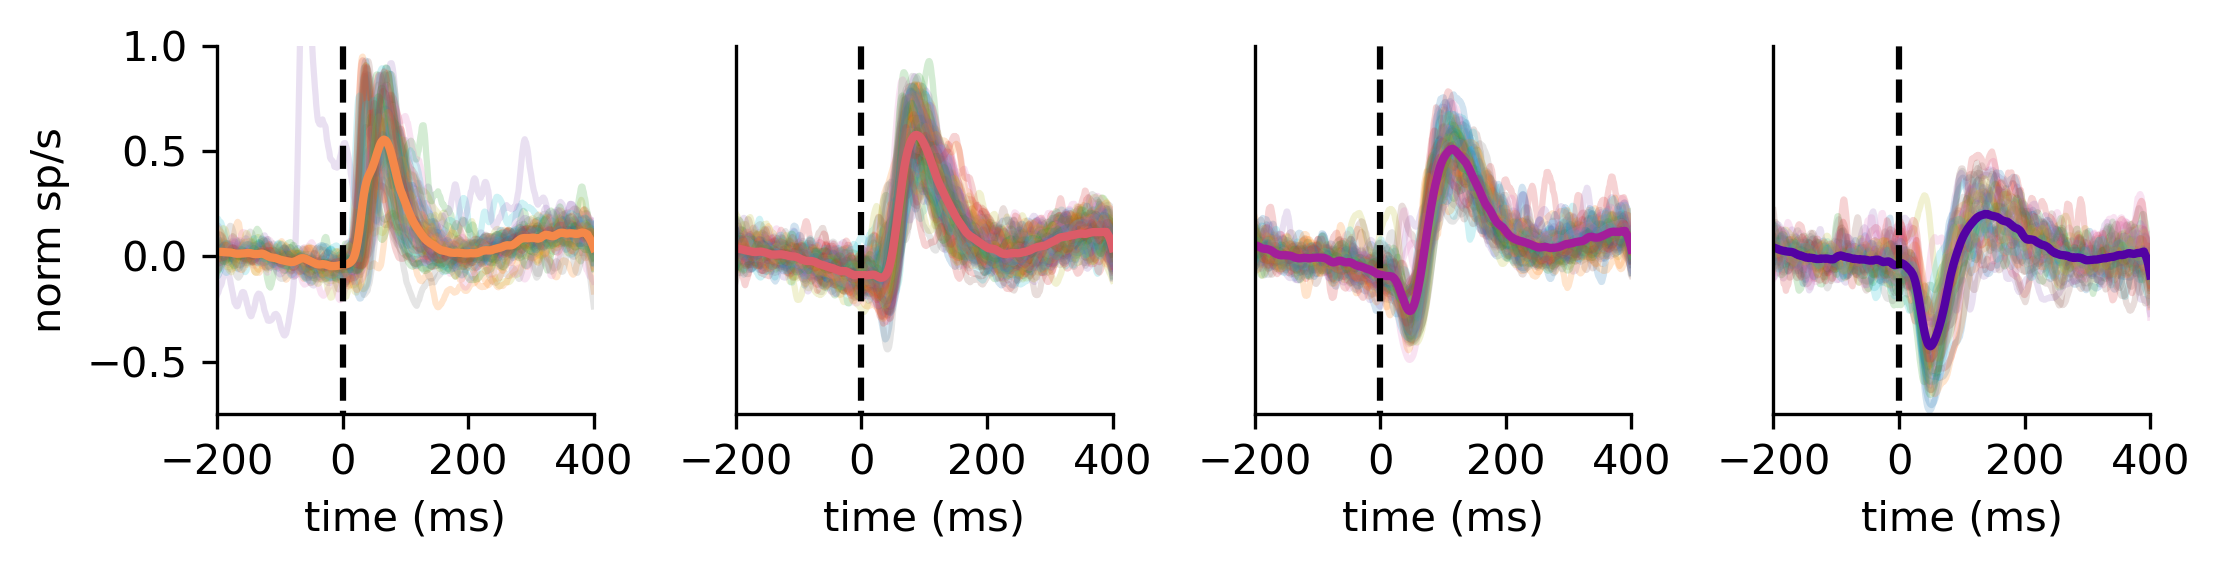

In [56]:
names = ['early','late','biphasic','negative']
fig, axs = plt.subplots(1,4,figsize=(7.5,2), dpi=300)
for ki, k in enumerate(kord):
    ax = axs[ki]
    inds = np.argwhere(clusters==k).flatten()
    for ind in inds:
        psth = norm_sacc_psth[ind,:]
        ax.plot(psth_bins, psth, alpha=0.2)
    ax.plot(psth_bins, np.nanmean(norm_sacc_psth[inds,:], axis=0), color=color_list[ki], linewidth=2)
    ax.set_ylim([-0.75,1])
    ax.vlines(0, -1, 1, color='k', linestyle='dashed')
    ax.set_xticks(np.linspace(-200,400,4))
    ax.set_xlim([-200,400])
    ax.set_xlabel('time (ms)')
    print(names[ki], len(inds))
    if ki>0:
        ax.set_yticks([])
    if ki==0:
        ax.set_ylabel('norm sp/s')
fig.tight_layout()
# fig.savefig(os.path.join(savepath, '6_clusters.pdf'))

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(4,3.25), dpi=300)
for ki, k in enumerate(kord):
    ax = axs.flatten()[ki]
    inds = np.argwhere(clusters==k).flatten()
    for ind in inds:
        psth = norm_sacc_psth[ind,:]
        ax.plot(psth_bins, psth, alpha=0.2)
    ax.plot(psth_bins, np.nanmean(norm_sacc_psth[inds,:], axis=0), color=color_list[ki], linewidth=2)
    ax.set_ylim([-0.8,1])
    ax.vlines(0, -1, 1, color='k', linestyle='dashed')
    ax.set_xticks(np.linspace(-200,400,4))
    ax.set_xlim([-200,400])
    if ki<2:
        ax.set_xticklabels([])
    if ki==0 or ki==2:
        ax.set_ylabel('norm sp/s')
    if ki>1:
        ax.set_xlabel('time (ms)')
fig.tight_layout()
fig.savefig(os.path.join(savepath, '6_clusters_sq.pdf'))

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(2.75,2), dpi=300)
for ki, k in enumerate(kord):
    inds = np.argwhere(clusters==k).flatten()
    for ind in inds:
        psth = norm_sacc_psth[ind,:]
        # ax.plot(psth_bins, psth, alpha=0.2)
    ax.plot(psth_bins, np.nanmean(norm_sacc_psth[inds,:], axis=0), color=color_list[ki], linewidth=2)
    ax.set_ylim([-.5,.7])
    ax.vlines(0, -1, 1, color='k', linestyle='dashed')
    
ax.set_xlim([-200,400])
ax.set_xticks(np.linspace(-200,400,4))
ax.set_xlabel('time (ms)')
ax.set_ylabel('norm sp/s')

fig.tight_layout()
fig.savefig(os.path.join(savepath, '6_all_clusters.pdf'))

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(2.5,2), dpi=300)
for ki, k in enumerate(kord):
    inds = np.argwhere(clusters==k).flatten()
    ax.scatter(proj[inds,0], proj[inds,1], s=1, c=color_list[ki])
ax.set_xlabel('PC 1'); ax.set_ylabel('PC 2')
ax.axis('equal')
# ax.set_ylim([-3,5])
# ax.set_xlim([-6,8])

fig.savefig(os.path.join(savepath, '6_pca.pdf'))

In [58]:
def plot_cprop_scatter(ax, data, clusters, color_list):
    for ki, k in enumerate(kord):
        
        inds = np.argwhere(clusters==k).flatten()
        kdata = data[inds].copy()
        
        x_jitter = np.random.uniform(ki-0.2, ki+0.2, np.size(kdata,0))
        
        ax.plot(x_jitter, kdata, '.', color=color_list[ki], markersize=2)
        
        hline = np.nanmedian(kdata)
        err = np.std(kdata) / np.sqrt(np.size(kdata))
        
        ax.hlines(hline, ki-0.2, ki+0.2, color='k', linewidth=2)
        ax.vlines(ki, hline-err, hline+err, color='k', linewidth=2)
        
        ax.set_xticks(range(4))
        ax.set_xticklabels(['early','late','biphasic','negative'])

In [59]:
from scipy import stats
def running_median(ax, x, y, n_bins=7):
    bins = np.linspace(np.min(x), np.max(x), n_bins)
    bin_means, bin_edges, bin_number = stats.binned_statistic(x[~np.isnan(x) & ~np.isnan(y)], y[~np.isnan(x) & ~np.isnan(y)], statistic=np.median, bins=bins)
    bin_std, _, _ = stats.binned_statistic(x[~np.isnan(x) & ~np.isnan(y)], y[~np.isnan(x) & ~np.isnan(y)], statistic=np.nanstd, bins=bins)
    hist, _ = np.histogram(x[~np.isnan(x) & ~np.isnan(y)], bins=bins)
    tuning_err = bin_std / np.sqrt(hist)
    ax.plot(bin_edges[:-1] + (np.median(np.diff(bins))/2), bin_means, '-', color='k')
    ax.fill_between(bin_edges[:-1] + (np.median(np.diff(bins))/2), bin_means-tuning_err, bin_means+tuning_err, color='k', alpha=0.2)

In [60]:
grat_resp = np.zeros(n_cells)
for ind in range(n_cells):
    ffi = np.sqrt(ori_index[ind]**2 + sf_index[ind]**2)
    if ffi >= 0.2:
        grat_resp[ind] = True
grat_resp = grat_resp.astype(bool)

In [44]:
use = np.argwhere(grat_resp).flatten()

vcounts = np.unique(clusters[use], return_counts=True)
vcounts[1][kord]

array([41, 88, 70, 39])

In [43]:
use = np.argwhere((grat_resp) * (peakT.flatten()>25) * (peakT.flatten()<160)).flatten()

vcounts = np.unique(clusters[use], return_counts=True)
vcounts[1][kord]

array([40, 88, 69, 29])

# tf and sf

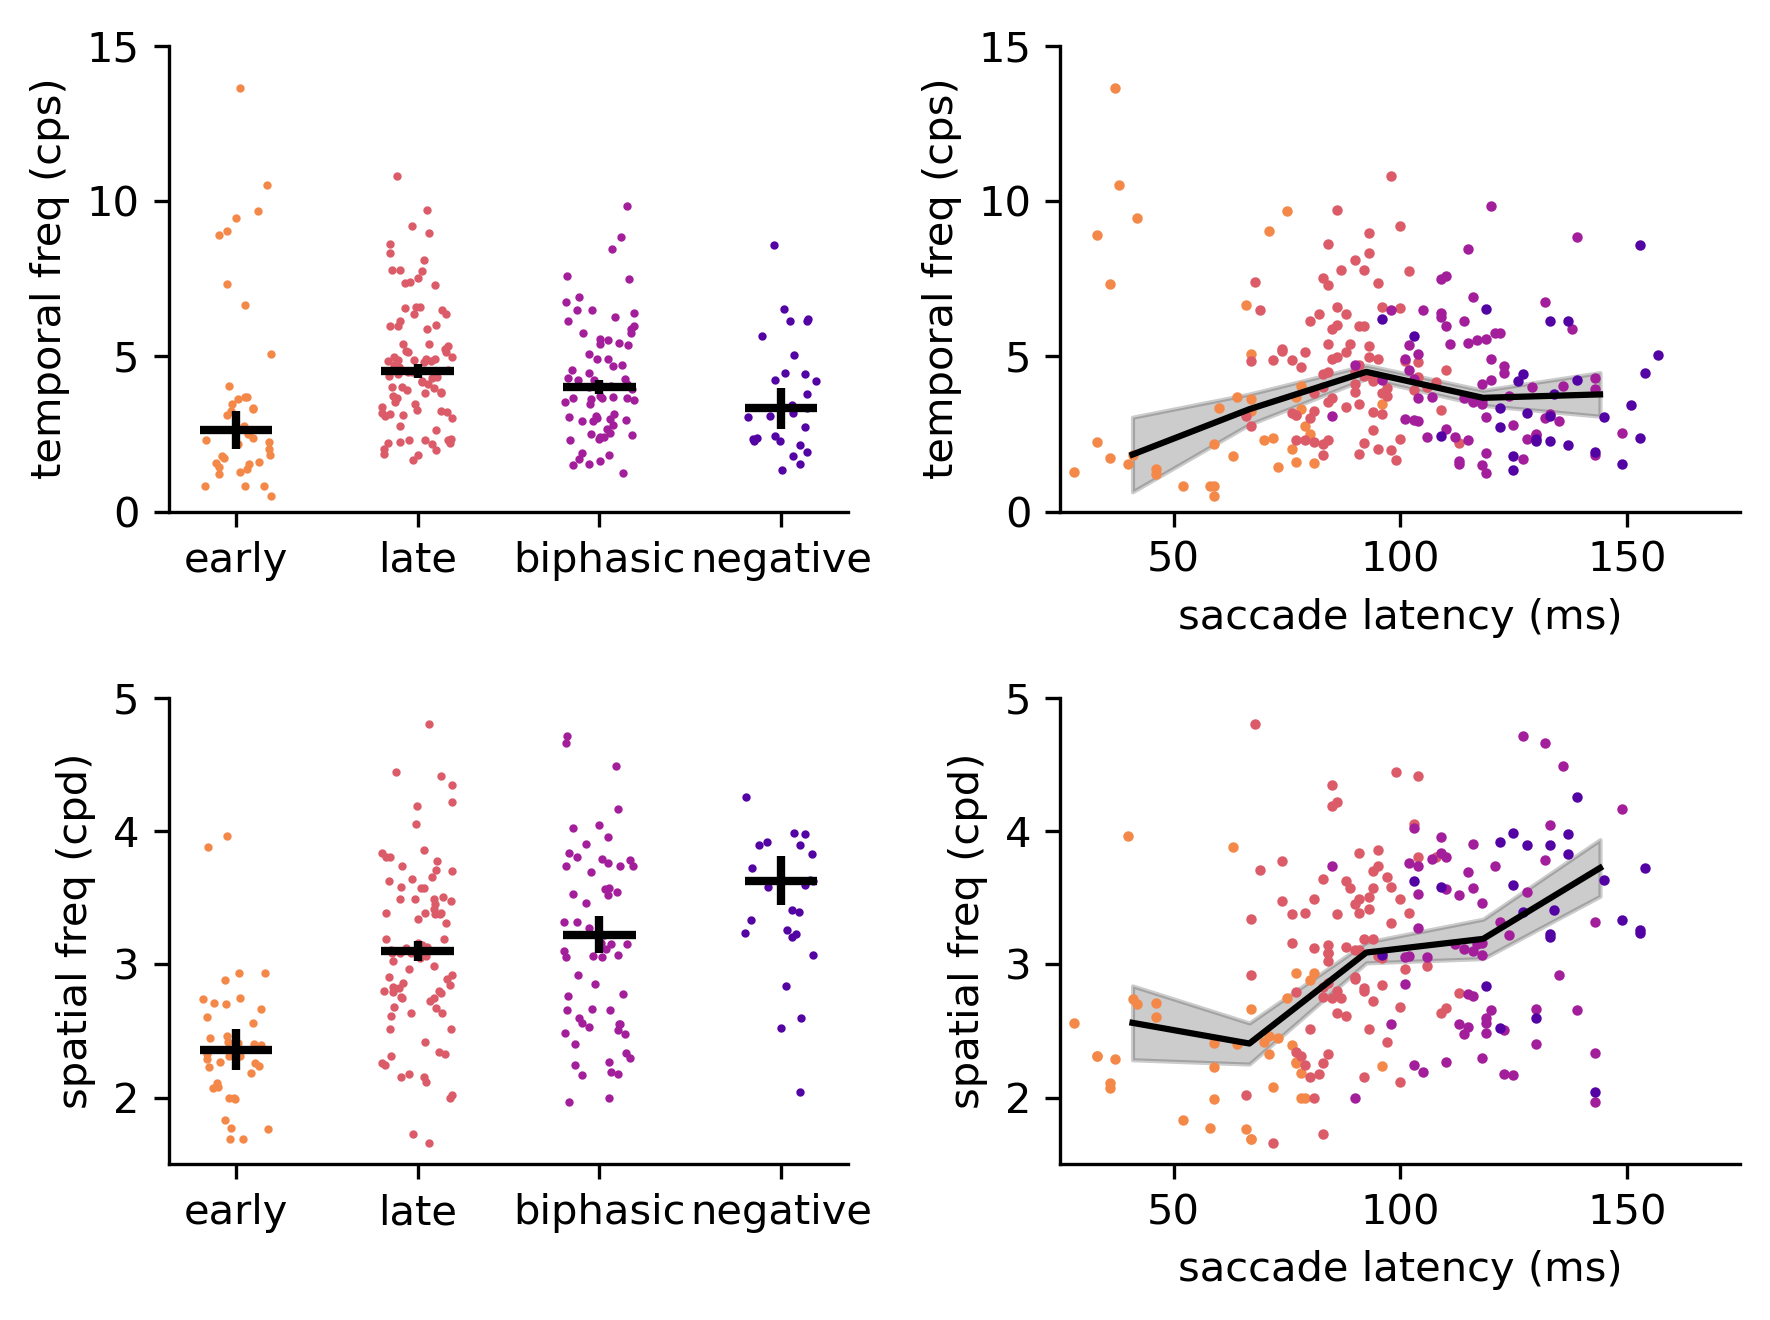

In [61]:
fig, [[ax0,ax1],[ax2,ax3]] = plt.subplots(2,2, figsize=(6,4.5), dpi=300)

# use = np.argwhere((grat_resp)).flatten()
use = np.argwhere((grat_resp) * (peakT.flatten()>25) * (peakT.flatten()<160)).flatten() # 25; 175 ms

plot_cprop_scatter(ax0, tf_pref[use], clusters[use], color_list)
ax0.set_ylabel('temporal freq (cps)')

plot_cprop_scatter(ax2, sf_pref[use], clusters[use], color_list)
ax2.set_ylabel('spatial freq (cpd)')

for ki, k in enumerate(kord):
    inds = np.intersect1d(np.argwhere((clusters==k)).flatten(), use)
    
    ax1.plot(peakT.flatten()[inds], tf_pref[inds], '.', color=color_list[ki], markersize=3)
    ax3.plot(peakT.flatten()[inds], sf_pref[inds], '.', color=color_list[ki], markersize=3)
    
running_median(ax1, peakT.flatten()[use], tf_pref[use], n_bins=6)
running_median(ax3, peakT.flatten()[use], sf_pref[use], n_bins=6)

ax1.set_xlabel('saccade latency (ms)')
ax3.set_xlabel('saccade latency (ms)')
ax1.set_ylabel('temporal freq (cps)')
ax3.set_ylabel('spatial freq (cpd)')
    
ax1.set_xlim([25,175])
ax3.set_xlim([25,175])
ax0.set_ylim([0, 15]); ax1.set_ylim([0, 15])
ax2.set_ylim([1.5, 5]); ax3.set_ylim([1.5, 5])

fig.tight_layout()

# fig.savefig(os.path.join(savepath, '6_sf_tf_scatter.pdf'))

In [62]:
from scipy.stats import spearmanr

In [65]:
use = np.argwhere(grat_resp).flatten()

spearmanr(peakT.flatten()[use], sf_pref[use])

SpearmanrResult(correlation=0.3126876721036976, pvalue=8.544421494516002e-07)

In [ ]:
(res.rvalue)**2

In [ ]:
res.pvalue

In [ ]:
len(peakT.flatten()[grat_resp])

In [ ]:
use = np.argwhere((grat_resp) * (peakT.flatten()>25) * (peakT.flatten()<150)).flatten()
np.unique(clusters[use], return_counts=True)

In [ ]:
len(use)

In [ ]:
latency_sort = np.argsort(peakT.flatten().copy())
tempseq = norm_sacc_psth.copy()[latency_sort]

In [24]:
def plot_tempseq(ax, seq):
    
    ax.set_xlabel('time (msec)')
    ax.set_ylim([np.size(seq,0),0])
    
    vmin = -0.75; vmax = 0.75
    img = ax.imshow(seq, cmap='coolwarm', vmin=vmin, vmax=vmax)
    
    ax.set_xlim([0,601])
    
    ax.set_xticks(np.linspace(0,600,4))
    ax.set_xticklabels(labels=np.linspace(-200,400,4).astype(int))
    ax.vlines(200, 0, np.size(seq,0), color='k', linestyle='dashed', linewidth=1)
    
    ax.set_aspect(3)
    
    return img

In [ ]:
fig, ax = plt.subplots(1,1, dpi=300, figsize=(5,5))
plot_tempseq(ax, tempseq)
ax.set_yticks(np.arange(0,np.size(tempseq,0),100))
fig.savefig(os.path.join(savepath, '6_tempseq.pdf'))

In [ ]:
0,2,3,1

In [ ]:
k_to_name = {
    0:'early',
    2:'late',
    3:'biphasic',
    1:'negative'
}

In [ ]:
sorted_clusters = clusters.copy()[latency_sort]

tempseq_legend = np.zeros([n_cells, 1, 4])
for ki, k in enumerate(sorted_clusters):
    tempseq_legend[ki,:,:] = kcolors[k_to_name[k]]

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(0.5,1.5), dpi=300)
ax.imshow(tempseq_legend, aspect=.05)
ax.set_yticks([]); ax.set_xticks([])
ax.axes.spines.bottom.set_visible(False)
ax.axes.spines.right.set_visible(False)
ax.axes.spines.left.set_visible(False)
ax.axes.spines.top.set_visible(False)
plt.tight_layout()
fig.savefig(os.path.join(savepath, '6_tempseq_legend.pdf'))

In [ ]:
fig, [ax_cellcounts, ax_baseline_fr] = plt.subplots(1,2, figsize=(5.5,2.5), dpi=300)

names = ['early','late','biphasic','negative']
print_names = ['early','late','biph','neg']

for ki, k in enumerate(kord):
    inds = np.argwhere((clusters==k)).flatten()
    ax_cellcounts.bar(ki, len(inds)/n_cells, color=color_list[ki])
    
ax_cellcounts.set_xticks(ticks=range(4))
ax_cellcounts.set_xticklabels(print_names, rotation=90)
ax_cellcounts.set_ylabel('frac. cells')

for ki, k in enumerate(kord):
    inds = np.argwhere((clusters==k)).flatten()
    bsln_plot_vals = bsln_fr[inds]
    
    err = np.nanstd(bsln_plot_vals) / np.sqrt(np.size(bsln_plot_vals))
    med = np.nanmedian(bsln_plot_vals)
    
    ax_baseline_fr.bar(ki, med, color=color_list[ki])
    ax_baseline_fr.plot([ki, ki], [med-err, med+err], 'k-')
    
ax_baseline_fr.set_xticks(range(4))
ax_baseline_fr.set_xticklabels(print_names, rotation=90)
ax_baseline_fr.set_ylabel('baseline (sp/s)')

fig.tight_layout()
fig.savefig(os.path.join(savepath, '6_ksize_bslnFr.pdf'))